## 1. Load Image

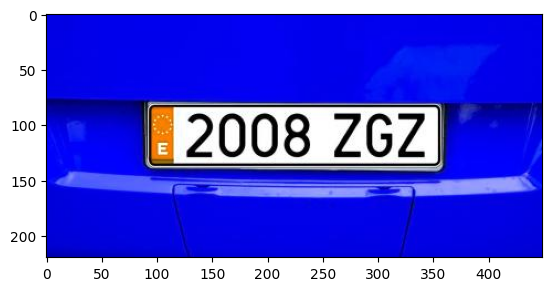

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Cargar imagen desde path
image = cv2.imread('img_exemple\exemple_matricula_es.jpeg')

# Mostar imagen
plt.imshow(image)

## 2. Convert color space

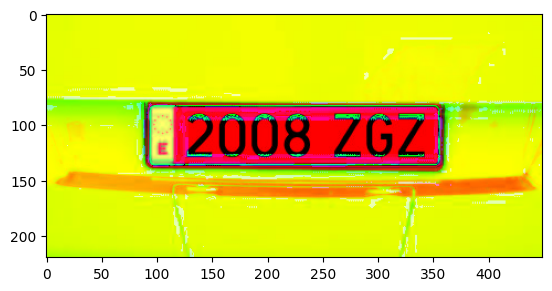

In [5]:
# Convertir imagen a espacio HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Show image
plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_BGR2RGB))
plt.show()

## 3. Binarize using Otsu

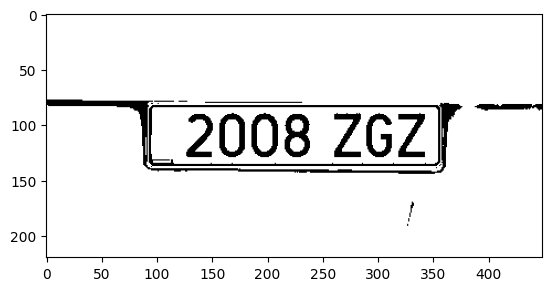

In [6]:
# Obtener el canal de valor (V) del HSV
v_channel = hsv[:,:,2]

# Binarizar la imagen usando el método de Otsu
_, binary_image = cv2.threshold(v_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Mostrar la imagen binarizada
plt.imshow(binary_image, cmap='gray')

## 4. Find contours

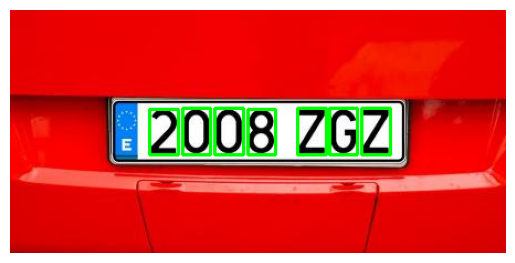

7


In [7]:
# Copiamos la imagen original para no modificarla
image_cp = image.copy()

# Encontrar contornos en la imagen binarizada
contours_letters, _ = cv2.findContours(binary_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
num_contours = 0

# Establecer umbrales para el área de los contornos
area_min = 400 
area_max = 900

# Dibujar un rectángulo sobre cada contorno
for contour in contours_letters:
    # Obtener las coordenadas del rectángulo que encierra el contorno
    x, y, w, h = cv2.boundingRect(contour)
    area = cv2.contourArea(contour)

    # Filtrar por área (demasiado pequeño o demasiado grande)
    if area_min < area < area_max:
        # Filtrar contornos que tocan los bordes (posición en los 0)
        if x > 0 and y > 0 and (x + w) < image_cp.shape[1] and (y + h) < image_cp.shape[0]:
            # Dibujar el rectángulo en la imagen
            cv2.rectangle(image_cp, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Verde, grosor 2
            num_contours += 1

# Mostrar la imagen con los contornos filtrados
plt.imshow(cv2.cvtColor(image_cp, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Opcional: para ocultar los ejes
plt.show()

print(num_contours)


## FUNCION COMPLETA

hem afegit que els contours s'afegeixin ordenats per la coordenada x, de esquerra a dreta.

<class 'numpy.ndarray'>


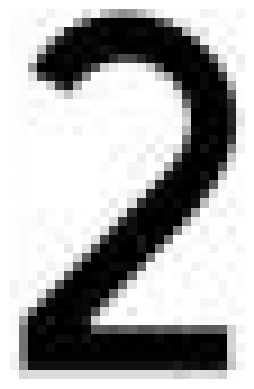

<class 'numpy.ndarray'>


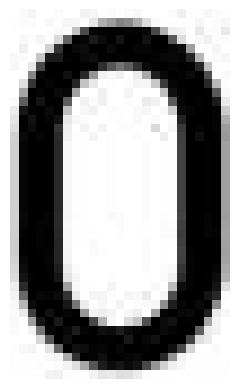

<class 'numpy.ndarray'>


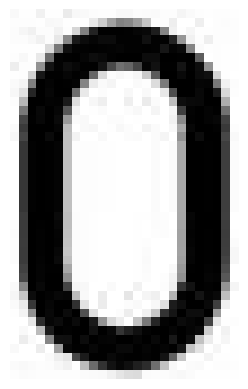

<class 'numpy.ndarray'>


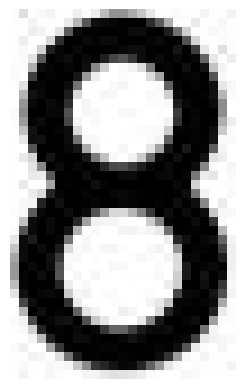

<class 'numpy.ndarray'>


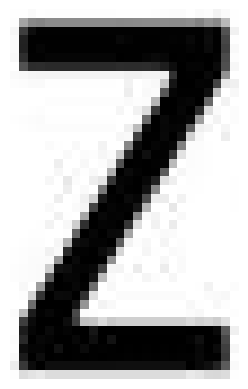

<class 'numpy.ndarray'>


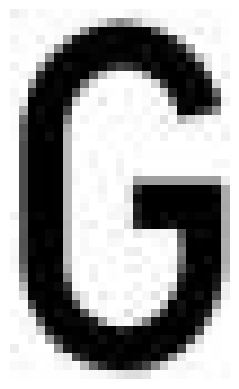

<class 'numpy.ndarray'>


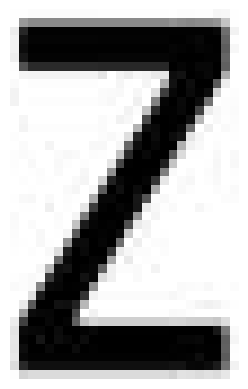

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def recortar_numeros_matricula(image_path):
    # Cargar imagen desde el path
    image = cv2.imread(image_path)

    # Convertir imagen a espacio HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Obtener el canal de valor (V) del HSV
    v_channel = hsv[:, :, 2]

    # Binarizar la imagen usando el método de Otsu
    _, binary_image = cv2.threshold(v_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Copiamos la imagen original para no modificarla
    image_cp = image.copy()

    # Pasar image_cp a escala de grises L
    image_cp = cv2.cvtColor(image_cp, cv2.COLOR_BGR2GRAY)

    # Encontrar contornos en la imagen binarizada
    contours_letters, _ = cv2.findContours(binary_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # Ordenar los contornos de izquierda a derecha
    contours_letters = sorted(contours_letters, key=lambda contour: cv2.boundingRect(contour)[0])

    # Establecer umbrales para el área de los contornos
    area_min = 400
    area_max = 900

    # Lista para almacenar los recortes de los números/letras
    digits_matricula = []

    # Dibujar un rectángulo sobre cada contorno y guardar los recortes
    for contour in contours_letters:
        # Obtener las coordenadas del rectángulo que encierra el contorno
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)

        # Filtrar por área (demasiado pequeño o demasiado grande)
        if area_min < area < area_max:
            # Filtrar contornos que tocan los bordes (posición en los 0)
            if x > 0 and y > 0 and (x + w) < image_cp.shape[1] and (y + h) < image_cp.shape[0]:
                # Recortar el contorno (número o letra)
                digit = image_cp[y:y + h, x:x + w]
                digits_matricula.append(digit)

    return digits_matricula

# Ejemplo de uso:
digits_matricula = recortar_numeros_matricula('img_exemple\exemple_matricula_es.jpeg')

# Mostrar cada recorte
for i, d in enumerate(digits_matricula):
    plt.imshow(cv2.cvtColor(d, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Opcional para ocultar los ejes
    plt.show()

# Guardar los recortes en digits_proves
for i, d in enumerate(digits_matricula):
    cv2.imwrite(f'digits_proves/digit_{i}.png', d)


## REDIMENSIONAR Y UNIFICAR TAMANY

In [22]:
from PIL import Image
import os

def redimensionar_con_relleno(imagen, tamaño=(40, 64)):
    """Redimensiona la imagen a un tamaño específico con relleno."""
    # Calcular la relación de aspecto de la imagen original
    ancho_original, alto_original = imagen.size
    relacion_aspecto_original = ancho_original / alto_original
    
    # Calcular el tamaño nuevo manteniendo la relación de aspecto
    if relacion_aspecto_original > (tamaño[0] / tamaño[1]):  # Imagen más ancha que el tamaño deseado
        nuevo_ancho = tamaño[0]
        nuevo_alto = int(nuevo_ancho / relacion_aspecto_original)
    else:  # Imagen más alta que el tamaño deseado
        nuevo_alto = tamaño[1]
        nuevo_ancho = int(nuevo_alto * relacion_aspecto_original)
    
    # Redimensionar la imagen
    imagen_redimensionada = imagen.resize((nuevo_ancho, nuevo_alto), Image.LANCZOS)

    # Crear una nueva imagen en blanco (relleno)
    imagen_final = Image.new('L', tamaño, color=255)  # Fondo blanco
    # Calcular la posición para centrar la imagen redimensionada
    posicion = ((tamaño[0] - nuevo_ancho) // 2, (tamaño[1] - nuevo_alto) // 2)
    # Pegar la imagen redimensionada en la nueva imagen
    imagen_final.paste(imagen_redimensionada, posicion)
    
    return imagen_final

def guardar_imagenes_recortadas_y_redimensionadas(carpeta_entrada, carpeta_salida):
    """Recorta y redimensiona imágenes en una carpeta."""
    if not os.path.exists(carpeta_salida):
        os.makedirs(carpeta_salida)
        
    for archivo in os.listdir(carpeta_entrada):
        if archivo.endswith(('.png', '.jpg', '.jpeg')):  # Filtrar imágenes
            # Cargar la imagen
            ruta_imagen = os.path.join(carpeta_entrada, archivo)
            imagen = Image.open(ruta_imagen)

            # Redimensionar la imagen con relleno
            imagen_redimensionada = redimensionar_con_relleno(imagen, tamaño=(40, 64))
            
            # Guardar la imagen redimensionada
            imagen_redimensionada.save(os.path.join(carpeta_salida, archivo))

# Uso
carpeta_entrada = 'digits_proves'  # Ajusta esta ruta
carpeta_salida = 'digits_proves_retallades'  # Ajusta esta ruta
guardar_imagenes_recortadas_y_redimensionadas(carpeta_entrada, carpeta_salida)


In [24]:
# show sizes digits_proves_retallades
for archivo in os.listdir(carpeta_salida):
    if archivo.endswith(('.png', '.jpg', '.jpeg')):  # Filtrar imágenes
        # Cargar la imagen
        ruta_imagen = os.path.join(carpeta_salida, archivo)
        imagen = Image.open(ruta_imagen)
        print(imagen.size)

(40, 64)
(40, 64)
(40, 64)
(40, 64)
(40, 64)
(40, 64)
(40, 64)
